---
## Transferencia de color

#### (Color transfer)
---

A continuación se presenta una aplicación del transporte óptimo en imagenes, la misma consiste en "trasnferir" los colores de una imagen a otra. Para esto, se utilizan que los pixeles de una imagen pueden verse como puntos en $R^3$ (una dimensión por cada color R-G-B) y por lo tanto, podemos aplicar transporte óptimo para llevar una distribución de colores a otra.

---

In [9]:
import numpy as np

import os
import ot 

from pathlib import Path
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Para replicar
rng = np.random.RandomState(42)

def im2mat(img):
    """Convierte una imagen (volumen (nw, nh, 3)) en una matriz (nw x nh, 3), un pixel por linea"""
    return img.reshape((img.shape[0] * img.shape[1], img.shape[2]))

def mat2im(X, shape):
    """Re-convertierte la matriz en la imagen"""
    return X.reshape(shape)

def minmax(img):
    """Topea los pixeles entre 0 y 1, es un reescalado"""
    return np.clip(img, 0, 1)

In [11]:
# Carga de imagenes
imagenes = os.path.abspath('imagenes_py')

imagen_1 = plt.imread(os.path.join(imagenes, 'fing.jpg')).astype(np.float64) / 256
imagen_2 = plt.imread(os.path.join(imagenes, 'aterdecer.jpg')).astype(np.float64) / 256

# Convertimos a matriz
X1 = im2mat(imagen_1)
X2 = im2mat(imagen_2)

# Datos para el entrenamiento: Dada la dimensionalidad del problema (nc x nh)
# elegimos al azar una cantidad menor de puntos, los cuales usaremos como densidades.
# A mayor cantidad de puntos más preciso será el transporte óptimo, pero también
# más costoso.
nb = 1000

# Elegimos nb valores al azar para cada color de la imagen (matriz)
# x1.shape[0]=nw x nh
idx1 = rng.randint(X1.shape[0], size=(nb,))
idx2 = rng.randint(X2.shape[0], size=(nb,))

# Datos de entrenamiento
Xs = X1[idx1, :]
Xt = X2[idx2, :]

Text(0.5, 1.0, 'Atardecer')

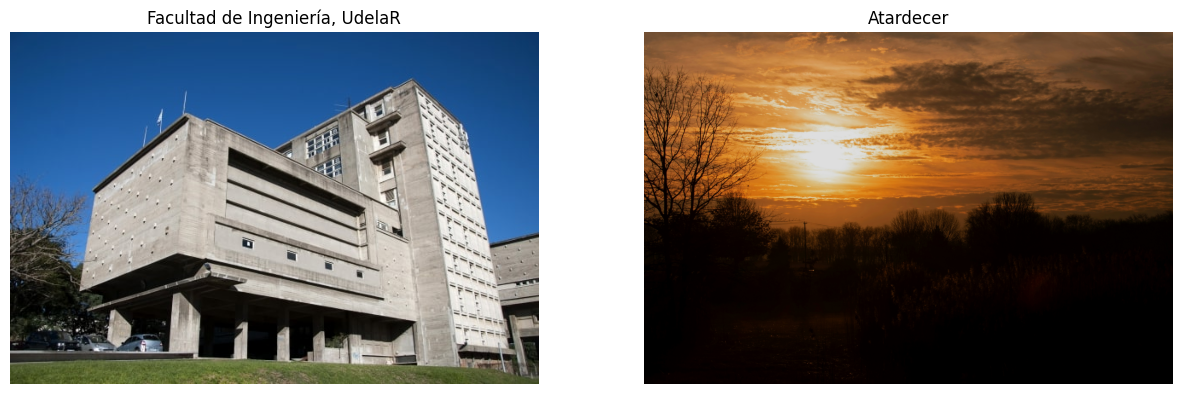

In [12]:
plt.figure(1, figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(imagen_1)
plt.axis('off')
plt.title('Facultad de Ingeniería, UdelaR')

plt.subplot(1, 2, 2)
plt.imshow(imagen_2)
plt.axis('off')
plt.title('Atardecer')

---
#### Scatter plot de los colores
---

/tmp/ipykernel_1098252/4145102773.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


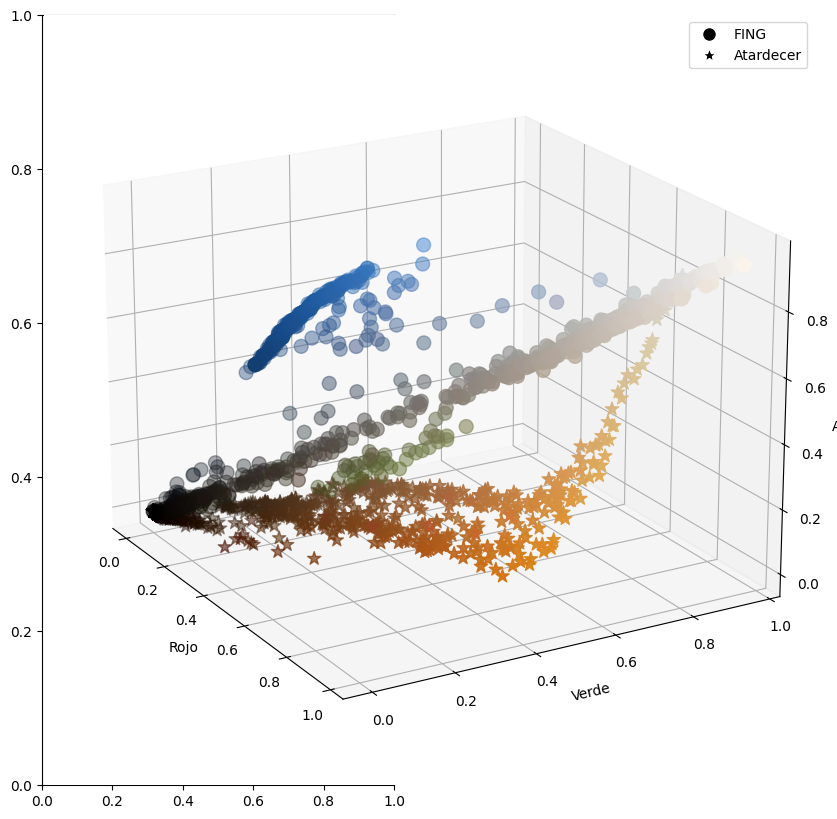

In [32]:
fig = plt.figure(2, figsize = (10, 10))
fig.add_subplot(111, projection='3d')

plt.subplot(1, 2, 1)
ax = fig.add_subplot(111, projection='3d')
scatter1 = ax.scatter(Xs[:, 0], Xs[:, 1], Xs[:, 2], c=Xs, marker='o', s=100, label="Atardecer")

scatter2 = ax.scatter(Xt[:, 0], Xt[:, 1], Xt[:, 2], c=Xt, marker='*', s=100, label = "FING")
ax.set_xlabel('Rojo')
ax.set_ylabel('Verde')
ax.set_zlabel('Azul')

legend = ax.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label='FING'),
    plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='black', markersize=10, label='Atardecer')
])

ax.set_facecolor('white')  
ax.view_init(elev=20, azim=-30)

---
### Transporte
---

In [38]:
# Kantorovich
ot_kantorovic = ot.da.EMDTransport()
ot_kantorovic.fit(Xs=Xs, Xt=Xt)
Xs_trasportado_kantorovich = ot_kantorovic.transform(Xs = X1)
imagen_kantorovich = minmax(mat2im(Xs_trasportado_kantorovich, imagen_1.shape))

# Sinkhorn
ot_sinkhorn = ot.da.SinkhornTransport(reg_e = 1e-1)
ot_sinkhorn.fit(Xs=Xs, Xt=Xt)
Xs_trasportado_sinkhorn = ot_sinkhorn.transform(Xs = X1)
imagen_sinkhorn = minmax(mat2im(Xs_trasportado_sinkhorn, imagen_1.shape))

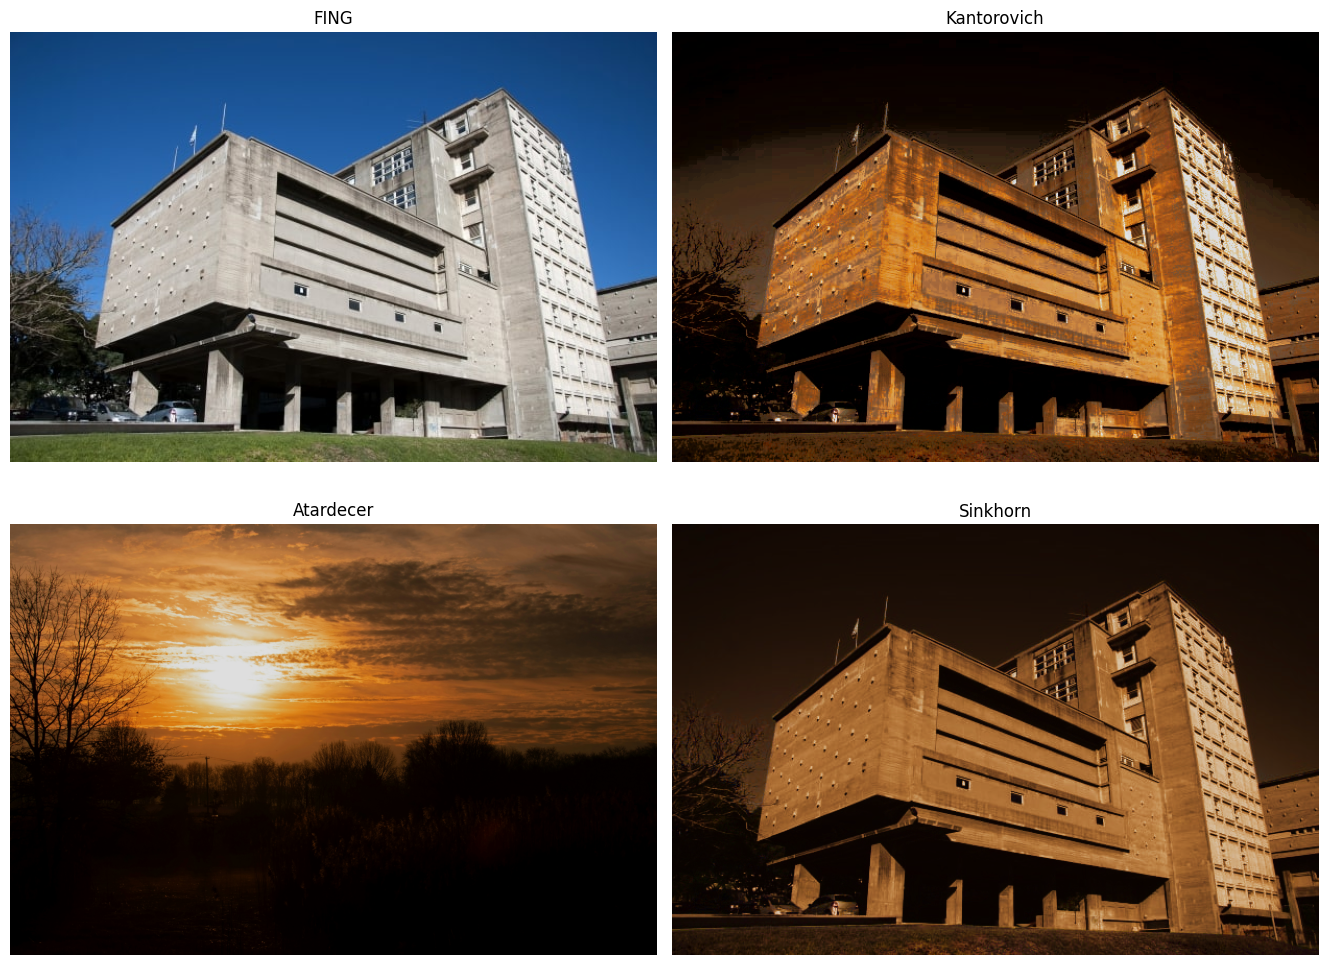

In [39]:
plt.figure(2, figsize=(20, 10))

plt.subplot(2, 3, 1)
plt.imshow(imagen_1)
plt.axis('off')
plt.title('FING')

plt.subplot(2, 3, 4)
plt.imshow(imagen_2)
plt.axis('off')
plt.title('Atardecer')

plt.subplot(2, 3, 2)
plt.imshow(imagen_kantorovich)
plt.axis('off')
plt.title('Kantorovich')

plt.subplot(2, 3, 5)
plt.imshow(imagen_sinkhorn)
plt.axis('off')
plt.title('Sinkhorn')

plt.tight_layout()
plt.show()


---
#### Efecto de regularización
---

In [40]:
# Reg 1e-2
ot_sinkhorn = ot.da.SinkhornTransport(reg_e=1e-2)                           # Iniciamos el objeto SinkhornTransport
ot_sinkhorn.fit(Xs=Xs, Xt=Xt)                                               # Calculamos el transporte óptimo
Xs_trasportado_sinkhorn = ot_sinkhorn.transform(Xs=X1)                      # Transformamos Xs utilizando el transporte óptimo
imagen_sinkhorn_neg_2 = minmax(mat2im(Xs_trasportado_sinkhorn, imagen_1.shape))   # Volvemos a convertir en una imagen (nw, nh, 3)

# Reg 1e-2
ot_sinkhorn = ot.da.SinkhornTransport(reg_e=1e-1)                           # Iniciamos el objeto SinkhornTransport
ot_sinkhorn.fit(Xs=Xs, Xt=Xt)                                               # Calculamos el transporte óptimo
Xs_trasportado_sinkhorn = ot_sinkhorn.transform(Xs=X1)                      # Transformamos Xs utilizando el transporte óptimo
imagen_sinkhorn_neg_1 = minmax(mat2im(Xs_trasportado_sinkhorn, imagen_1.shape))   # Volvemos a convertir en una imagen (nw, nh, 3)

# Reg 1
ot_sinkhorn = ot.da.SinkhornTransport(reg_e=1)                              # Iniciamos el objeto SinkhornTransport
ot_sinkhorn.fit(Xs=Xs, Xt=Xt)                                               # Calculamos el transporte óptimo
Xs_trasportado_sinkhorn = ot_sinkhorn.transform(Xs=X1)                      # Transformamos Xs utilizando el transporte óptimo
imagen_sinkhorn_1 = minmax(mat2im(Xs_trasportado_sinkhorn, imagen_1.shape))   # Volvemos a convertir en una imagen (nw, nh, 3)

# Reg 1e2
ot_sinkhorn = ot.da.SinkhornTransport(reg_e=1e2)                            # Iniciamos el objeto SinkhornTransport
ot_sinkhorn.fit(Xs=Xs, Xt=Xt)                                               # Calculamos el transporte óptimo
Xs_trasportado_sinkhorn = ot_sinkhorn.transform(Xs=X1)                      # Transformamos Xs utilizando el transporte óptimo
imagen_sinkhorn_2 = minmax(mat2im(Xs_trasportado_sinkhorn, imagen_1.shape))   # Volvemos a convertir en una imagen (nw, nh, 3)

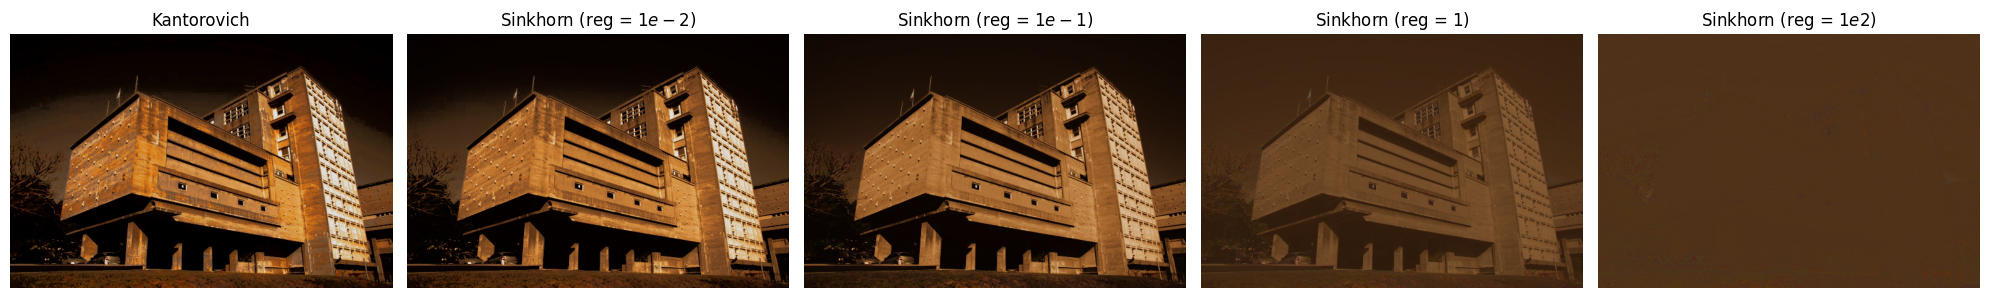

In [55]:
plt.figure(3, figsize=(20, 10))

plt.subplot(1, 5, 1)
plt.imshow(imagen_kantorovich)
plt.axis('off')
plt.title('Kantorovich')

plt.subplot(1, 5, 2)
plt.imshow(imagen_sinkhorn_neg_2)
plt.axis('off')
plt.title(r'Sinkhorn (reg = $1e-2$)')

plt.subplot(1, 5, 3)
plt.imshow(imagen_sinkhorn_neg_1)
plt.axis('off')
plt.title(r'Sinkhorn (reg = $1e-1$)')


plt.subplot(1, 5, 4)
plt.imshow(imagen_sinkhorn_1)
plt.axis('off')
plt.title(r'Sinkhorn (reg = $1$)')


plt.subplot(1, 5, 5)
plt.imshow(imagen_sinkhorn_2)
plt.axis('off')
plt.title(r'Sinkhorn (reg = $1e2$)')


plt.tight_layout()
plt.show()